---
### Simplified System of linear equations solving for image $X$

Key terms:

$L$ = one-dimensional size for high-resolution image

$M$ = one-dimensional size for low-resolution image

$X$ = $L^2 \times 1$ column vector, represents the ideal image we are trying to recover via solving

$Y_i$ = $M^2 \times 1$ column vector, represents a decimated, downsampled, blurred, noisy image based on $X$

$N$ = the number of low-resolution images

$D$ = the decimation matrix operator of size $M^2 \times L^2$

$H$ = the blur matrix operator of size $L^2 \times L^2$

$S$ = the sharpening operator of size $L^2 \times L^2$, i.e., the laplacian operator

$w_i$ = a weighting scalar, a "confidence factor" for each $Y_i$ (eventually a diagonal matrix?)

$\beta$ = smoothing factor for controlling image sharpening

---

Objective: to solve for $X$ (i.e., $AX = B$) based on the following equation:

$\begin{bmatrix}
  \beta S^T S + (\sum\limits_{i=1}^N w_i) H^TD^TDH
\end{bmatrix}X = \sum\limits_{i=1}^N (w_iH^TD^TY_i)$

---

General information:

- Dataset: GLEAM Small
- Timesteps: 30
- Receivers: 512
- Channels: 1
- $L$ = 100 pixels
- $M$ = 50 pixels
- $N$ = 6 images (30 timesteps / 5 timesteps per image)
- $w_i$ = 1 for all images
- $\beta$ = 1 (I guess?)

Asumptions:
1. The blur kernel $H$ is uniform across all instances of $Y$
2. The decimatimation kernel $D$ is uniform across all instances of $Y$
3. The $w_i$ is uniform across all instances of $Y$, just a confidence of 1.0 ("full confidence")

---

To do:

- [x] Generate 6 dataset subsets, containing timesteps each (i.e., 30 time steps / 5 time steps per file)
- [x] Generate one point spread function per dataset subset, for analysis of different
- [x] Generate one point spread function for the whole dataset
- [x] Determine if there is a significant difference between a subset PSF and the full dataset PSF - this will be the blur kernel
- [ ] Determine if the PSF can be reduced (i.e., dont use the full PSF) - what effects might this have?
- [x] Generate an IDFT of the full dataset, $L^2$ pixels
- [x] Genetate an IDFT for each of the subsets, $M^2$ pixels
- [x] Come up with a formula for populating the decimation matrix
- [ ] Come up with a formula for populating the blur matrix 
- [ ] Determine if there is a formula for populating the product of the blur and decimation matrix, such that $H^TD^T = (HD)^T$

---

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import data, io, color
from skimage.transform import resize


plt.rcParams['figure.figsize'] = [10, 10]

def show_image(image, title):
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def normalise(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def rrmse(observed, ideal, decimal=6):
    return "{:.{}f}".format(np.sqrt((1 / observed.shape[0]**2) * np.sum((observed-ideal)**2) / np.sum(ideal**2)) * 100.0, decimal)

def decimation_matrix(l, m):
    d_matrix = np.zeros((m**2, l**2), dtype=np.float32)

    tile = np.repeat((1, 0, 1), (2, l - 2, 2)) # assuming taking 2 neighbours per dimension
    t_len = tile.shape[0]
    d = l // m
    r_offset = m**2 // 2
    c_offset = l**2 // 2

    for p in np.arange(l//4): # divide by 4 as 4 neighbours total
        p_offset = p * l
        for q in np.arange(m):
            d_matrix[q+ p_offset//2, q*d + p_offset*2 : q*d+t_len + p_offset*2] = tile # top-left quadrant
            d_matrix[q+r_offset + p_offset//2, q*d+c_offset + p_offset*2: q*d+t_len+c_offset + p_offset*2] = tile # bottom-right quadrant
    return d_matrix

# produces convolution matrix of size l**2 by l**2, where each row is populated by the convolution kernel values at the appropriate neighbours
# note: assumes kernel is a two-dimensonal numpy array of some size n by n
def convolution_matrix(l, kernel):
    
    conv = np.zeros((l**2, l**2), dtype=np.float32)
    full_supp = kernel.shape[0] # assumed square
    half_supp = (full_supp - 1) // 2

    for conv_row in np.arange(l**2):

        row, col = (conv_row // l, conv_row % l)

        for k_row in np.arange(-(half_supp), half_supp + 1):
            # map "kernel row" to rows in conv
            mapped_row = row + k_row
            # ignore any out of bounds rows
            if mapped_row >= 0 and mapped_row < l:
                linear_col = col - half_supp
                # truncate negative columns
                mapped_col_start = max(linear_col, 0)
                # truncate columns which exceed the l dimension
                mapped_col_end = min(linear_col + full_supp, l)
                # left trimming for kernels when overlapping out of bounds region in conv (col < 0)
                left = np.absolute(col - half_supp) if linear_col < 0 else 0
                # right trimming for kernels when overlapping out of bounds region in conv (col >= l)
                right = linear_col + full_supp - l if linear_col + full_supp >= l else 0 
                # copy over kernel row for current k_row, possibly including trimming for out of bounds coordinates
                conv[conv_row][mapped_row * l + mapped_col_start : mapped_row * l + mapped_col_end] = kernel[k_row + half_supp][left: left + full_supp - right]
    return conv

#### Configuration and data set up...

In [2]:
timesteps = 30 # total timesteps
timesteps_per_y = 5
l = 100
m = 50
n = timesteps // timesteps_per_y
β = 10.0 # sharpening factor
w = np.ones(n) # y image weightings, eventually driven by visibility weights

# all time steps direct image
filename = "../data/direct_image_ts_0_29.bin"
x_true = np.fromfile(filename, dtype=np.float32)
x_true = x_true.reshape(l, l)
x_true = normalise(x_true)
# show_image(x_true, "True X")

# all time steps direct psf
filename = "../data/direct_psf_ts_0_29.bin"
x_psf = np.fromfile(filename, dtype=np.float32)
# x_psf = x_psf.reshape(l, l)[1:, 1:] # trim row 0 and all column 0 (to ensure odd dimensions with the peak in the center)
x_psf /= np.max(x_psf)

trim_half_len = 2
psf_min = l//2 - (trim_half_len - 1)
psf_max = l//2 + trim_half_len
x_psf = x_psf.reshape(l, l)[psf_min:psf_max, psf_min:psf_max]

# x_psf = np.zeros((l, l))
# x_psf[50, 50] = 1.0
# show_image(x_psf, "Trimmed PSF")
# plt.plot(x_psf[x_psf.shape[0]//2])

# trim PSF to small bounds, normalised

# Storing all low-res images as layered stack
y = np.zeros((n, m, m))

# batched time steps direct images
for i in np.arange(n):
    filename = f"../data/direct_image_ts_{i * timesteps_per_y}_{i * timesteps_per_y + timesteps_per_y - 1}.bin"
    y[i] = np.fromfile(filename, dtype=np.float32).reshape(m, m)
    y[i] = normalise(y[i])
    # show_image(y[i], f"$Y_{i}$")
    
# batched time steps point spread functions
# for i in np.arange(N):
#     start = i * timesteps_per_y
#     end = start + timesteps_per_y - 1
#     filename = "../data/direct_psf_ts_%d_%d.bin" % (start, end)
#     Y_i_psf = np.fromfile(filename, dtype=np.float32)
#     Y_i_psf = Y_i_psf.reshape(L, L)
#     # show_image(Y_i_psf, "$Y_{%d}$ PSF" % i)

# Decimation matrix
d = decimation_matrix(l, m) # takes the sum of 4 l neighbours to form 1 m pixel

# Blur matrix (psf)
h = convolution_matrix(l, x_psf)

# Sharpening matrix (laplacian)
laplacian = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
s = convolution_matrix(l, laplacian)

#### Setting up the right hand side of the equation $AX = B$, where $B = \sum\limits_{i=1}^N (w_iH^TD^TY_i)$

In [3]:
b = np.zeros(l**2, dtype=np.float32)

for i in np.arange(n):
    b += np.matmul(w[i] * h.T, np.matmul(d.T, y[i].flatten()))
                     
# show_image(normalise(b.reshape(l, l)), "B")

#### Setting up the right hand side of the equation $AX=B$, where $A = \begin{bmatrix}
  \beta S^T S + (\sum\limits_{i=1}^N w_i) H^TD^TDH
\end{bmatrix}$

In [4]:
lhs = β * np.matmul(s.T, s)
rhs = (h.T @ d.T @ d @ h) * np.sum(w)
a = lhs + rhs
# ow_image(a.reshape(l**2, l**2), "A")

#### Now solve for $X$...

RRMSE: Solved X and True X -> 0.396422


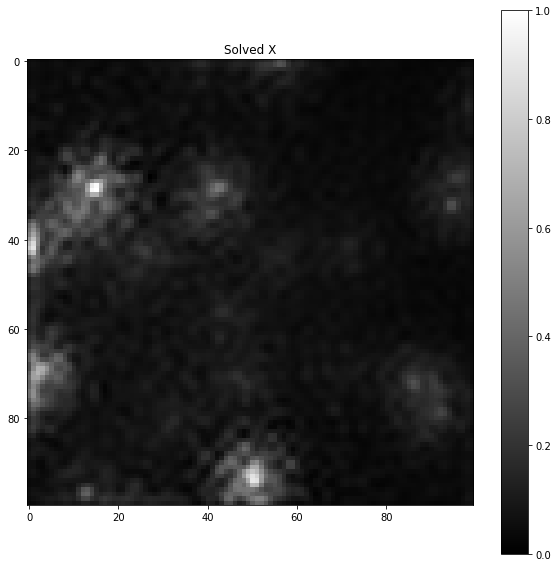

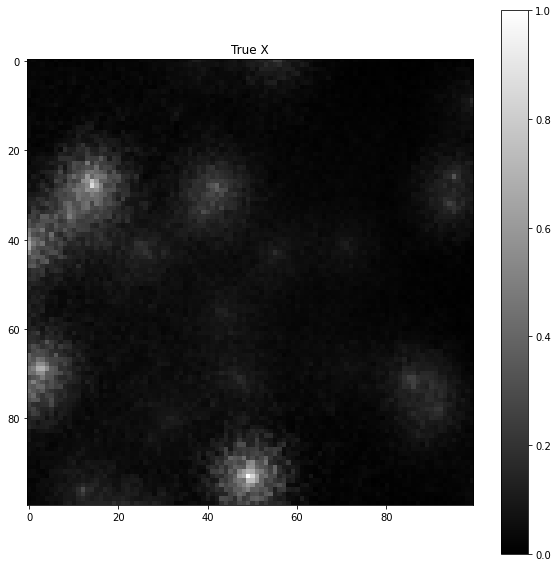

In [5]:
# Look here for options regarding solving the sparse matrix problem - seems to be plenty of algorithms to choose from
# https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html

x = np.linalg.solve(a, b)
x = x.reshape(100, 100)

# b_true = np.matmul(normalise(a), x_true.flatten())
# x_accurate = np.linalg.solve(a, b_true)
# x_accurate = x_accurate.reshape(100, 100)

# show_image(normalise(x), "Solved X")
# print(f"RRMSE: B and True B -> {rrmse(normalise(b.reshape(l, l)), normalise(b_true.reshape(l, l)))}")
# print(f"L2 between B and True X: {np.sqrt(np.sum((normalise(b.reshape(l, l))-normalise(x))**2))}")
# show_image(normalise(b.reshape(l, l)), "B")
# show_image(normalise(b_true.reshape(l, l)), "True B")

# print(f"RRMSE: X and Accurate X -> {rrmse(normalise(x), normalise(x_accurate))}")
# print(f"RRMSE: Accurate X and True X -> {rrmse(normalise(x_accurate), normalise(x_true))}")
print(f"RRMSE: Solved X and True X -> {rrmse(normalise(x), normalise(x_true))}")

show_image(normalise(x), "Solved X")
# show_image(normalise(x_accurate[10:l-11, 10:l-11]), "Solved X using True X (IDFT)")
# show_image(normalise(x_accurate), "Solved X using True X (IDFT)")
show_image(normalise(x_true), "True X")